In [1]:
import pandas as pd
import numpy as np
from collections import Counter
pd.options.display.max_rows=100

In [2]:
all_labels = pd.read_pickle('/home/prateekagarw_umass_edu/p_file/all_labels')
all_labels

,image_name,adjective_1,adjective_2,negative_adj,object_1,object_2
0,p_0.jpg,bigger,smaller,"[bluer, hairier]",dogs,
1,p_1.jpg,cleaner,dirtier,[bigger],hands,
2,p_2.jpg,hairier,balder,"[longer, thicker]",cats,
3,p_3.jpg,younger,older,"[denser, cleaner]",persons,
4,p_5.jpg,colder,hotter,"[fuller, curvier]",drinks,
...,...,...,...,...,...,...
252,k_60.jpg,fatter,skinnier,"[narrower, fancier, taller]",people,
253,k_61.jpg,nearer,farther,"[heavier, bluer, smoother]",objects,
254,k_62.jpg,shinier,duller,"[heavier, curvier, curlier]",piggybank,santa
255,k_63.jpg,fatter,skinnier,"[drier, broader, blacker]",fishes,


In [3]:
#Modeling 
import pandas as pd
import os
import glob
import numpy as np
import time
import requests
import random
import matplotlib.pyplot as plt
from PIL import Image
import requests
import torch
import torch.nn as nn
from transformers import CLIPProcessor, CLIPModel
model_name = "openai/clip-vit-base-patch32"
# model_name = "openai/clip-vit-large-patch14"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

In [4]:
#Make a dictionary mapping adjectives to antonyms
adjective_df = pd.read_csv("/home/prateekagarw_umass_edu/p_file/truncated_adj_aug.csv")
adjective_pairs = {}
for pairs in zip(adjective_df['Comparative'],adjective_df['Comparative.1']):
    adj1,adj2 = pairs
    adjective_pairs[adj1] = adj2
print(len(adjective_pairs.keys()))
adjective_pairs

39


{'bigger': 'smaller',
 'heavier': 'lighter',
 'fatter': 'skinnier',
 'thicker': 'thinner',
 'narrower': 'wider',
 'harder': 'softer',
 'denser': 'None',
 'taller': 'shorter',
 'longer': 'shorter',
 'blacker': 'whiter',
 'darker': 'lighter',
 'bluer': 'None',
 'brighter': 'dimmer',
 'broader': 'slimmer',
 'cleaner': 'dirtier',
 'clearer': 'cloudier',
 'sunnier': 'cloudier',
 'coarser': 'finer',
 'smoother': 'rougher',
 'colder': 'hotter',
 'curlier': 'straighter',
 'curvier': 'straighter',
 'deeper': 'shallower',
 'drier': 'wetter',
 'fancier': 'plainer',
 'nearer': 'farther',
 'fewer': 'more',
 'flakier': 'None',
 'flatter': 'rounder',
 'fuller': 'emptier',
 'hairier': 'balder',
 'higher': 'lower',
 'newer': 'older',
 'younger': 'older',
 'fresher': 'staler',
 'riper': 'rawer',
 'sharper': 'blunter',
 'rustier': 'None',
 'shinier': 'duller'}

In [5]:
#make prompts
adj_prompts_list = []
adjectives_list = list(adjective_pairs.keys())
for adj in adjective_pairs.keys():
    if adjective_pairs[adj]!="None":
        adj_prompts_list.append(f'The objects in this image can be compared using the adjective "{adj}" and "{adjective_pairs[adj]}"') 
    else:
        adj_prompts_list.append(f'The objects in this image can be compared using the adjective "{adj}"')  

In [7]:
#make a list of prompts
groundtruth_labels = [ ]
scores = [ ]
accuracy = 0
predicted_indices = []
wrong_adjectives = [ ]
wrong_images = [ ]
k=10
for idx,row in all_labels.iterrows():
    
  img_name, adjective, antonym = row['image_name'],row['adjective_1'],row['adjective_2']
  
  img_path = "/home/prateekagarw_umass_edu/p_file/all_aug/" + img_name
  img = Image.open(img_path)

  groundtruth_labels.append(adjectives_list.index(adjective))
  
  inputs = processor(text=adj_prompts_list, images=img, return_tensors="pt", padding=True).to(device)
  outputs = model(**inputs).logits_per_image
  probs = outputs.softmax(dim=1) 
  scores.append(probs.cpu().detach().numpy())
    
  prob, idxs = probs[0].topk(10)
  top_adj_prompts = [adjectives_list[i] for i in idxs[:k]]
    
  if adjective not in top_adj_prompts:
        wrong_adjectives.append(adjective)
        wrong_images.append(img_name)
        print(img_name, adjective, top_adj_prompts[0])
  # prob, idxs = probs[0].topk(39)
  # top_adj_prompts = [unique_adjectives[i] for i in idxs[:k]]
  # print("groundtruth adjective is "+ adjective + " and its antonym is " + antonym)
  # predicted_index = top_adj_prompts.index(correct_adjective)
  # avg_index += predicted_index
  # predicted_indices.append(predicted_index)
  # print(top_adj_prompts)
  # plt.figure(figsize=(8, 10))
  # plt.imshow(np.asarray(img))
  # plt.show()
 
#   if antonym!="None" and antonym in top_adj_prompts:
#     accuracy+=1
#   if adjective in top_adj_prompts:
#     accuracy+=1
#   else:
#     continue
# print(accuracy/len(img_name_list))
# print(avg_index/len(sided_df["adjective"]))

p_7.jpg harder curlier
p_17.jpg heavier harder
p_23.jpg fuller thicker
p_27.jpg shinier cleaner
p_29.jpg smoother riper
p_30.jpg rustier sharper
p_35.jpg coarser blacker
p_37.jpg fuller fancier
p_44.jpg nearer younger
p_49.jpg narrower cleaner
p_51.jpg thicker fresher
p_56.jpg higher fancier
p_62.jpg rustier fresher
p_63.jpg rustier cleaner
p_65.jpg blacker newer
p_69.jpg smoother flatter
p_72.jpg thicker sharper
p_74.jpg shinier newer
p_76.jpg darker thicker
p_80.jpg fewer younger
p_81.jpg flakier fatter
p_84.jpg fuller flatter
l_1.jpg curvier bluer
l_6.jpg fuller fancier
l_8.jpg deeper flatter
l_9.jpg blacker thicker
l_11.jpg bigger curlier
l_16.jpg darker heavier
l_21.jpg bigger fresher
l_29.jpg rustier cleaner
l_31.jpg nearer narrower
l_32.jpg denser bluer
l_38.jpg cleaner thicker
l_44.jpg flakier fatter
l_45.jpg deeper shinier
l_46.jpg fuller fresher
d_6.jpg nearer smoother
d_7.jpg fuller newer
d_12.jpg fuller newer
d_17.jpg darker coarser
d_19.jpg nearer coarser
d_20.jpg higher h

In [8]:
adjective_error_analysis = Counter(wrong_adjectives)
print(adjective_error_analysis)

Counter({'nearer': 10, 'fuller': 9, 'darker': 8, 'rustier': 5, 'smoother': 4, 'thicker': 4, 'bigger': 4, 'heavier': 3, 'higher': 3, 'blacker': 3, 'deeper': 3, 'denser': 3, 'drier': 3, 'broader': 3, 'harder': 2, 'shinier': 2, 'narrower': 2, 'fewer': 2, 'flakier': 2, 'curvier': 2, 'clearer': 2, 'fancier': 2, 'coarser': 1, 'cleaner': 1, 'fatter': 1, 'longer': 1, 'brighter': 1, 'bluer': 1})


1 0.22178988326848248
3 0.4085603112840467
5 0.5369649805447471
10 0.6614785992217899
15 0.7587548638132295
20 0.8326848249027238
25 0.9066147859922179
30 0.9494163424124513
35 0.9844357976653697


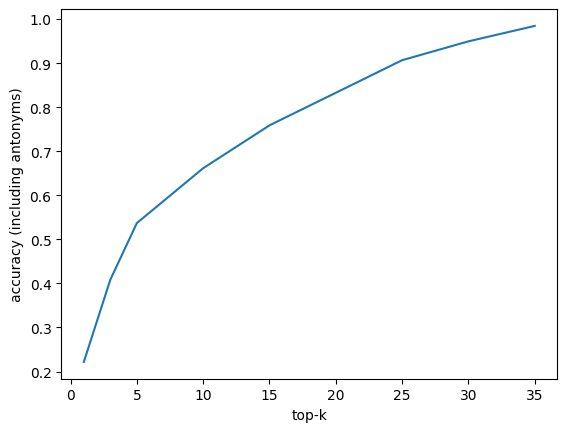

In [9]:
scores_np = np.asarray(scores).squeeze(1)
from sklearn.metrics import top_k_accuracy_score
k_s = [1,3,5,10,15,20,25,30,35]
k_scores = [ ]
for k in k_s:
  k_score = top_k_accuracy_score(np.array(groundtruth_labels),np.asarray(scores).squeeze(1),k = k)
  print(str(k) +" "+ str(k_score))
  k_scores.append(k_score)
k_scores = np.array(k_scores)
np.save('wAntonymsScores',k_scores)

plt.plot(k_s,k_scores)
plt.xlabel("top-k")
plt.ylabel("accuracy (including antonyms)")
plt.show()